# Предобработка + выделение признаков с моей записи:

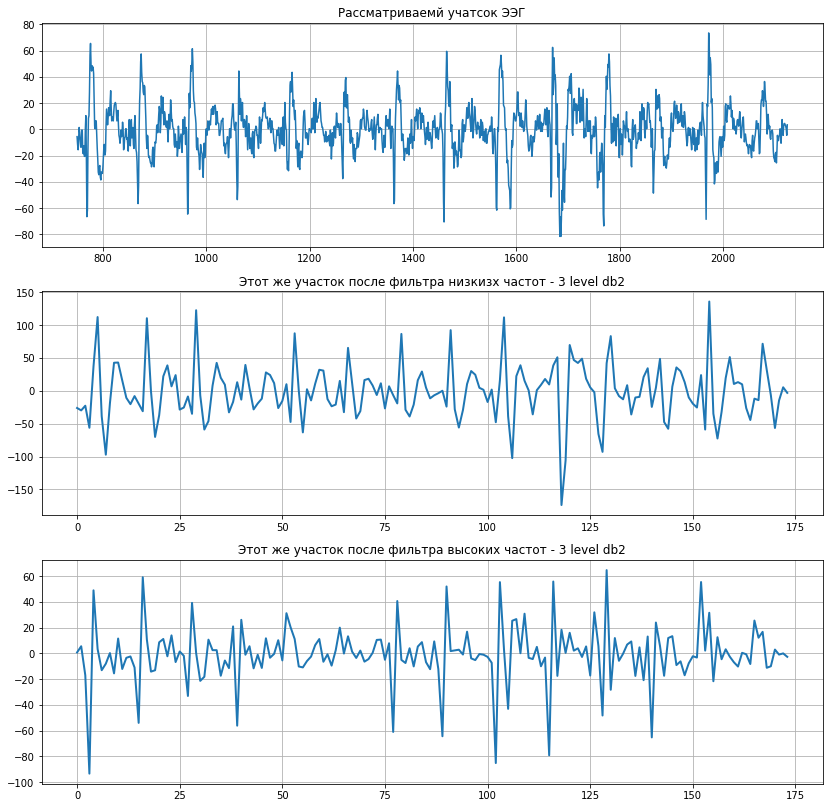

In [38]:
# моя запись


import pywt
import pylab
import pyedflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *

f = pyedflib.EdfReader('2021.02.19-19.19.11.787.edf')  
n = f.signals_in_file  
signal_labels = f.getSignalLabels() 
sigbufs = np.zeros((n, f.getNSamples()[0]))

for i in np.arange(n):
    sigbufs[i, :] = f.readSignal(i)
    
f.close()

chanel_num = 3     # номер рассматриваемого канала
start_sec = 6      # начало учатска
stop_sec = 17      # конец участка

x_data = [i for i in range(len(sigbufs[chanel_num]))][start_sec * 125 : stop_sec * 125]
y_data = [sigbufs[chanel_num][i] for i in range(len(sigbufs[chanel_num]))][start_sec * 125 : stop_sec * 125]

st = 'db2'        # тип преобразования
lvl = 3           # уровень преобразования (кол-во применений к данному сигналу)

cA = pywt.downcoef('a', y_data, st, mode = 'reflect', level = lvl)
cD = pywt.downcoef('d', y_data, st, mode = 'reflect', level = lvl)

plt.figure(figsize = (14, 14))
subplot(3, 1, 1)
title("Рассматриваемй учатсок ЭЭГ")
plot(x_data, y_data)
grid()

subplot(3, 1, 2)
title("Этот же участок после фильтра низкизх частот - 3 level %s"%st)
plt.plot([i for i in range(len(cA))], cA, linewidth = 2)
grid()

subplot(3, 1, 3)
title("Этот же участок после фильтра высоких частот - 3 level %s"%st)
plt.plot([i for i in range(len(cD))], cD, linewidth = 2)
grid()

plt.show()

In [39]:
#нахождение пика и его границ

data = copy(cA)
threshold = 0.46
columns_ = ['Left', 'Max', 'Zero', 'Min', 'Right']
index_ = [i for i in range(int(1.5 * (stop_sec - start_sec)))]
peaks_ind_df = pd.DataFrame(index = index_, columns = columns_)

#steps_num = len(data)
#steps_num = (int(stop_sec - start_sec) * 125)//(2 ** lvl)

for i in range(int(1.5 * (stop_sec - start_sec))): #предполагается, что моргают уж никак не чаще чем полтора раза в секунду
    
    #поиск max:
    max_ = max(data)
    max_ind =  np.where(data == max_)[0][0]
    
    #поиск min:
    min_ = min(data[max_ind : max_ind + 6])
    min_ind =  np.where(data == min_)[0][0]
    
    #нахождение левого/правого концов пика:
    if (abs(min_/max_) >= threshold) and (min_ * max_ < 0):
        
        for j in range(6):
            if data[max_ind - j] < 0.05 * max_:
                left_ind = max_ind - j
                break
        
        for j in range(6):
            if data[min_ind + j] > 0.05 * min_:
                right_ind = min_ind + j
                break
                
    #запись в датафрейм
    peaks_ind_df['Max'][i] = max_ind
    peaks_ind_df['Min'][i] = min_ind 
    peaks_ind_df['Left'][i] = left_ind
    peaks_ind_df['Right'][i] = right_ind
    
    #нахождение точки пересения нуля:
    peaks_ind_df['Zero'][i] = max_ind + (min_ind - max_ind) * (max_ / (max_ - min_))
    
    #обнуляем в копии записи место, в котором нашли пик
    data[left_ind : right_ind] = 0
    
    #если точкизакончились
    if (i >= 1) and ((peaks_ind_df['Right'][i - 1] == right_ind) or (peaks_ind_df['Left'][i - 1] == left_ind)):
        peaks_ind_df = peaks_ind_df.drop(index_[i:])
        break
        
peaks_ind_df = peaks_ind_df.sort_values('Left').reset_index(drop = True)
peaks_ind_df

,Left,Max,Zero,Min,Right
0,3,5,6.07222,7,9
1,16,17,18.2236,19,21
2,28,29,30.3511,31,33
3,52,53,54.1612,55,56
4,90,91,92.2462,93,95
5,102,104,105.044,106,107
6,153,154,155.304,156,158


In [40]:
def zero_intersection(x_1, x_2):
    return x_1 + (x_2 - x_1) * ( data[x_1] / (data[x_1] - data[x_2]))

    
data = copy(cA)
len_df = len(peaks_ind_df)
columns_ = ['Left', 'Max', 'Center', 'Min', 'Right']
index_ = [i for i in range(len_df)]
true_pos_df = pd.DataFrame(index = index_, columns = columns_)

for i in range(len_df):
    
    left_ind = peaks_ind_df['Left'][i]
    max_ind = peaks_ind_df['Max'][i]
    min_ind = peaks_ind_df['Min'][i]
    right_ind = peaks_ind_df['Right'][i]
    
    true_pos_df['Left'][i] = zero_intersection(left_ind, max_ind)
    true_pos_df['Max'][i] = max_ind
    true_pos_df['Center'][i] = zero_intersection(max_ind, min_ind)
    true_pos_df['Min'][i] = min_ind
    true_pos_df['Right'][i] = zero_intersection(min_ind, right_ind)
    
true_pos_df

,Left,Max,Center,Min,Right
0,3.66694,5,6.07222,7,8.38895
1,16.2193,17,18.2236,19,20.5206
2,28.2216,29,30.3511,31,32.7663
3,52.3511,53,54.1612,55,55.9632
4,90.2063,91,92.2462,93,94.6868
5,102.599,104,105.044,106,106.821
6,153.302,154,155.304,156,157.577


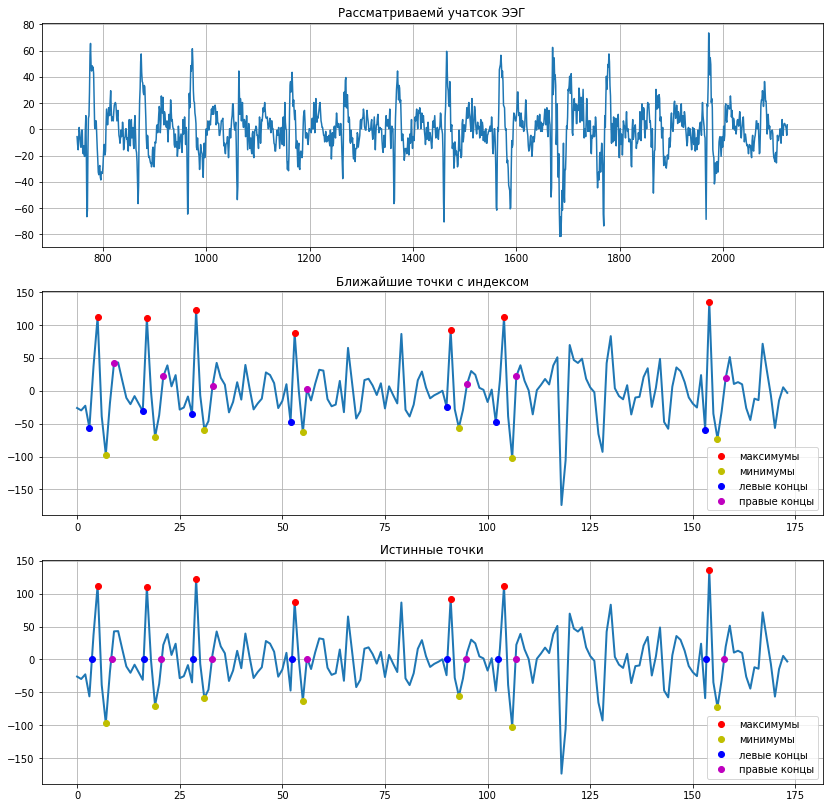

In [41]:

plt.figure(figsize = (14, 14))

subplot(3, 1, 1)
title("Рассматриваемй учатсок ЭЭГ")
plot(x_data, y_data)
grid()



subplot(3, 1, 2)
title("Ближайшие точки с индексом")
plt.plot([i for i in range(len(cA))], cA, linewidth = 2)

len_df = len(peaks_ind_df['Max'])
tmp = [peaks_ind_df['Max'][i] for i in range(len_df)]
plt.plot(tmp, cA[tmp], 'ro', label = 'максимумы')


tmp = [peaks_ind_df['Min'][i] for i in range(len_df)]
plt.plot(tmp, cA[tmp], 'yo', label = 'минимумы')


tmp = [peaks_ind_df['Left'][i] for i in range(len_df)]
plt.plot(tmp, cA[tmp], 'bo', label = 'левые концы')


tmp = [peaks_ind_df['Right'][i] for i in range(len_df)]
plt.plot(tmp, cA[tmp], 'mo', label = 'правые концы')

#tmp = [peaks_ind_df['Zero'][i] for i in range(len_df)]
#plt.plot(tmp, [0] * len_df, 'ko', label = 'точки пересечения нуля')

grid()
legend(loc = 'best')



subplot(3, 1, 3)
title("Истинные точки")
plt.plot([i for i in range(len(cA))], cA, linewidth = 2)

len_df = len(true_pos_df['Max'])
tmp = [true_pos_df['Max'][i] for i in range(len_df)]
plt.plot(tmp, cA[tmp], 'ro', label = 'максимумы')


tmp = [true_pos_df['Min'][i] for i in range(len_df)]
plt.plot(tmp, cA[tmp], 'yo', label = 'минимумы')


tmp = [true_pos_df['Left'][i] for i in range(len_df)]
plt.plot(tmp, [0] * len_df, 'bo', label = 'левые концы')


tmp = [true_pos_df['Right'][i] for i in range(len_df)]
plt.plot(tmp,  [0] * len_df, 'mo', label = 'правые концы')

#tmp = [peaks_ind_df['Zero'][i] for i in range(len_df)]
#plt.plot(tmp, [0] * len_df, 'ko', label = 'точки пересечения нуля')

grid()
legend(loc = 'best')

plt.show()

In [42]:
# Фичи

data = copy(cA)
columns_ = ['User', 'Max_A', 'Min_A', 'Max_pos', 'Min_pos', 'Left_tan','Center_tan', 'Right_tan', 'Left_s', 'Right_s']
index_ = [i for i in range(len_df)]
features_df_1 = pd.DataFrame(index = index_, columns = columns_)

for i in range(len_df):
    
    features_df_1['User'][i] = 1
    
    features_df_1['Max_A'][i] = data[peaks_ind_df['Max'][i]]
    features_df_1['Min_A'][i] = data[peaks_ind_df['Min'][i]]
    
    features_df_1['Max_pos'][i] = peaks_ind_df['Zero'][i] - peaks_ind_df['Max'][i]
    features_df_1['Min_pos'][i] = peaks_ind_df['Min'][i] - peaks_ind_df['Zero'][i]
    
    features_df_1['Left_tan'][i] = (data[peaks_ind_df['Max'][i]] - data[peaks_ind_df['Left'][i]]) / (peaks_ind_df['Max'][i] - peaks_ind_df['Left'][i])
    features_df_1['Right_tan'][i] = (data[peaks_ind_df['Right'][i]] - data[peaks_ind_df['Min'][i]]) / (peaks_ind_df['Right'][i] - peaks_ind_df['Min'][i])
    features_df_1['Center_tan'][i] = (data[peaks_ind_df['Min'][i]] - data[peaks_ind_df['Max'][i]]) / (peaks_ind_df['Min'][i] - peaks_ind_df['Max'][i])

    features_df_1['Left_s'][i] = 0.5 * data[peaks_ind_df['Max'][i]] * (peaks_ind_df['Zero'][i] - true_pos_df['Left'][i])
    features_df_1['Right_s'][i] = 0.5 * data[peaks_ind_df['Min'][i]] * (true_pos_df['Right'][i] - peaks_ind_df['Zero'][i])

features_df_1

,User,Max_A,Min_A,Max_pos,Min_pos,Left_tan,Center_tan,Right_tan,Left_s,Right_s
0,1,112.187,-97.0752,1.07222,0.927784,84.1579,-104.631,69.8909,134.92,-112.449
1,1,110.408,-70.0542,1.22361,0.776387,141.413,-90.2311,46.0698,110.649,-80.4572
2,1,122.555,-58.8623,1.35108,0.648915,157.45,-90.7087,33.326,130.488,-71.0812
3,1,87.4625,-63.1818,1.16118,0.838821,134.791,-75.3221,65.5937,79.1558,-56.9283
4,1,92.296,-55.8249,1.24622,0.753775,116.287,-74.0605,33.0961,94.1379,-68.1211
5,1,111.688,-102.331,1.04372,0.956277,79.6989,-107.01,124.643,136.545,-90.9346
6,1,135.788,-72.4867,1.30393,0.696067,194.63,-104.138,45.9743,135.898,-82.372


# Предобоработка + выделение признаков с записи Волида:

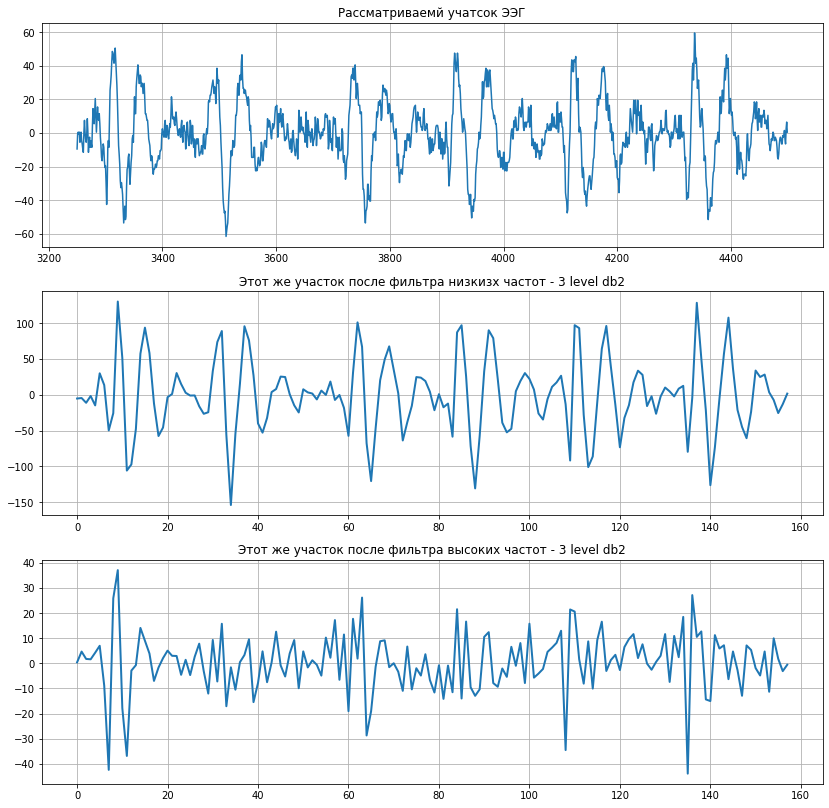

In [43]:
f = pyedflib.EdfReader('2021.02.19-19.33.49.168.edf')  
n = f.signals_in_file  
signal_labels = f.getSignalLabels() 
sigbufs = np.zeros((n, f.getNSamples()[0]))

for i in np.arange(n):
    sigbufs[i, :] = f.readSignal(i)
    
f.close()

chanel_num = 3     # номер рассматриваемого канала
start_sec = 26      # начало учатска
stop_sec = 36      # конец участка

x_data = [i for i in range(len(sigbufs[chanel_num]))][start_sec * 125 : stop_sec * 125]
y_data = [sigbufs[chanel_num][i] for i in range(len(sigbufs[chanel_num]))][start_sec * 125 : stop_sec * 125]

st = 'db2'        # тип преобразования
lvl = 3           # уровень преобразования (кол-во применений к данному сигналу)

cA = pywt.downcoef('a', y_data, st, mode = 'reflect', level = lvl)
cD = pywt.downcoef('d', y_data, st, mode = 'reflect', level = lvl)

plt.figure(figsize = (14, 14))
subplot(3, 1, 1)
title("Рассматриваемй учатсок ЭЭГ")
plot(x_data, y_data)
grid()

subplot(3, 1, 2)
title("Этот же участок после фильтра низкизх частот - 3 level %s"%st)
plt.plot([i for i in range(len(cA))], cA, linewidth = 2)
grid()

subplot(3, 1, 3)
title("Этот же участок после фильтра высоких частот - 3 level %s"%st)
plt.plot([i for i in range(len(cD))], cD, linewidth = 2)
grid()

plt.show()

In [44]:

data = copy(cA)
threshold = 0.56
columns_ = ['Left', 'Max', 'Zero', 'Min', 'Right']
index_ = [i for i in range(int(1.5 * (stop_sec - start_sec)))]
peaks_ind_df = pd.DataFrame(index = index_, columns = columns_)

#steps_num = len(data)
#steps_num = (int(stop_sec - start_sec) * 125)//(2 ** lvl)

for i in range(int(1.5 * (stop_sec - start_sec))): #предполагается, что моргают уж никак не чаще чем полтора раза в секунду
    
    #поиск max:
    max_ = max(data)
    max_ind =  np.where(data == max_)[0][0]
    
    #поиск min:
    min_ = min(data[max_ind : max_ind + 6])
    min_ind =  np.where(data == min_)[0][0]
    
    #нахождение левого/правого концов пика:
    if (abs(min_/max_) >= threshold) and (min_ * max_ < 0):
        
        #поиск левого края
        for j in range(6):
            if data[max_ind - j] < 0.05 * max_:
                left_ind = max_ind - j
                break
        
        #поиск правого края
        for j in range(6):
            if data[min_ind + j] > 0.05 * min_:
                right_ind = min_ind + j
                break
                
        #запись в датафрейм
        peaks_ind_df['Max'][i] = max_ind
        peaks_ind_df['Min'][i] = min_ind 
        peaks_ind_df['Left'][i] = left_ind
        peaks_ind_df['Right'][i] = right_ind

        #нахождение точки пересения нуля:
        peaks_ind_df['Zero'][i] = max_ind + (min_ind - max_ind) * (max_ / (max_ - min_))
    
    k = 3
    
    #обнуляем в копии записи место, в котором нашли пик
    data[left_ind - k : right_ind + k] = 0
    
    #если точкизакончились
    if (i >= 1) and ((peaks_ind_df['Right'][i - 1] == right_ind) or (peaks_ind_df['Left'][i - 1] == left_ind)):
        peaks_ind_df = peaks_ind_df.drop(index_[i:])
        break
        
peaks_ind_df = peaks_ind_df.sort_values('Left').reset_index(drop = True)
peaks_ind_df

,Left,Max,Zero,Min,Right
0,8,9,10.1034,11,14
1,60,62,63.3688,65,67
2,83,85,86.2789,88,90
3,109,110,111.472,113,116
4,136,137,138.513,140,142


In [45]:
#найдём истинные точки пересения нуля 

def zero_intersection(x_1, x_2):
    return x_1 + (x_2 - x_1) * ( data[x_1] / (data[x_1] - data[x_2]))

    
data = copy(cA)
len_df = len(peaks_ind_df)
columns_ = ['Left', 'Max', 'Center', 'Min', 'Right']
index_ = [i for i in range(len_df)]
true_pos_df = pd.DataFrame(index = index_, columns = columns_)

for i in range(len_df):
    
    left_ind = peaks_ind_df['Left'][i]
    max_ind = peaks_ind_df['Max'][i]
    min_ind = peaks_ind_df['Min'][i]
    right_ind = peaks_ind_df['Right'][i]
    
    true_pos_df['Left'][i] = zero_intersection(left_ind, max_ind)
    true_pos_df['Max'][i] = max_ind
    true_pos_df['Center'][i] = zero_intersection(max_ind, min_ind)
    true_pos_df['Min'][i] = min_ind
    true_pos_df['Right'][i] = zero_intersection(min_ind, right_ind)
    
true_pos_df

,Left,Max,Center,Min,Right
0,8.1647,9,10.1034,11,12.9445
1,60.7237,62,63.3688,65,66.7105
2,83.7517,85,86.2789,88,89.5985
3,109.486,110,111.472,113,114.834
4,136.029,137,138.513,140,142.096


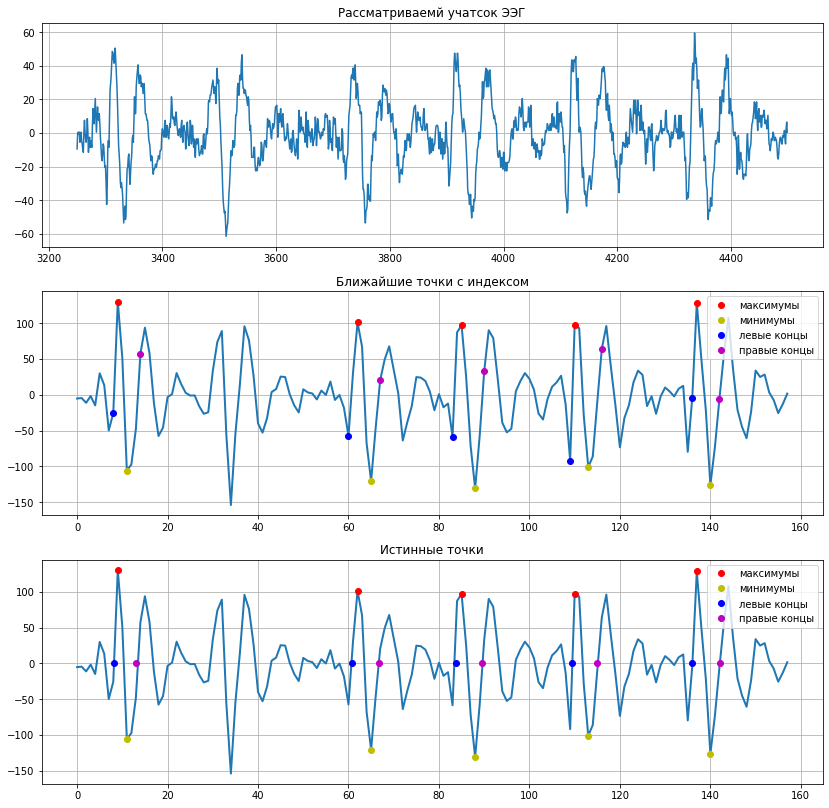

In [46]:
#визуализация пика

plt.figure(figsize = (14, 14))

subplot(3, 1, 1)
title("Рассматриваемй учатсок ЭЭГ")
plot(x_data, y_data)
grid()



subplot(3, 1, 2)
title("Ближайшие точки с индексом")
plt.plot([i for i in range(len(cA))], cA, linewidth = 2)

len_df = len(peaks_ind_df['Max'])
tmp = [peaks_ind_df['Max'][i] for i in range(len_df)]
plt.plot(tmp, cA[tmp], 'ro', label = 'максимумы')


tmp = [peaks_ind_df['Min'][i] for i in range(len_df)]
plt.plot(tmp, cA[tmp], 'yo', label = 'минимумы')


tmp = [peaks_ind_df['Left'][i] for i in range(len_df)]
plt.plot(tmp, cA[tmp], 'bo', label = 'левые концы')


tmp = [peaks_ind_df['Right'][i] for i in range(len_df)]
plt.plot(tmp, cA[tmp], 'mo', label = 'правые концы')

#tmp = [peaks_ind_df['Zero'][i] for i in range(len_df)]
#plt.plot(tmp, [0] * len_df, 'ko', label = 'точки пересечения нуля')

grid()
legend(loc = 'best')



subplot(3, 1, 3)
title("Истинные точки")
plt.plot([i for i in range(len(cA))], cA, linewidth = 2)

len_df = len(true_pos_df['Max'])
tmp = [true_pos_df['Max'][i] for i in range(len_df)]
plt.plot(tmp, cA[tmp], 'ro', label = 'максимумы')


tmp = [true_pos_df['Min'][i] for i in range(len_df)]
plt.plot(tmp, cA[tmp], 'yo', label = 'минимумы')


tmp = [true_pos_df['Left'][i] for i in range(len_df)]
plt.plot(tmp, [0] * len_df, 'bo', label = 'левые концы')


tmp = [true_pos_df['Right'][i] for i in range(len_df)]
plt.plot(tmp,  [0] * len_df, 'mo', label = 'правые концы')

#tmp = [peaks_ind_df['Zero'][i] for i in range(len_df)]
#plt.plot(tmp, [0] * len_df, 'ko', label = 'точки пересечения нуля')

grid()
legend(loc = 'best')

plt.show()

In [47]:
# фичи

data = copy(cA)
columns_ = ['User', 'Max_A', 'Min_A', 'Max_pos', 'Min_pos', 'Left_tan','Center_tan', 'Right_tan', 'Left_s', 'Right_s']
index_ = [i for i in range(len_df)]
features_df_2 = pd.DataFrame(index = index_, columns = columns_)

for i in range(len_df):
    
    features_df_2['User'][i] = 2
    
    features_df_2['Max_A'][i] = data[peaks_ind_df['Max'][i]]
    features_df_2['Min_A'][i] = data[peaks_ind_df['Min'][i]]
    
    features_df_2['Max_pos'][i] = peaks_ind_df['Zero'][i] - peaks_ind_df['Max'][i]
    features_df_2['Min_pos'][i] = peaks_ind_df['Min'][i] - peaks_ind_df['Zero'][i]
    
    features_df_2['Left_tan'][i] = (data[peaks_ind_df['Max'][i]] - data[peaks_ind_df['Left'][i]]) / (peaks_ind_df['Max'][i] - peaks_ind_df['Left'][i])
    features_df_2['Right_tan'][i] = (data[peaks_ind_df['Right'][i]] - data[peaks_ind_df['Min'][i]]) / (peaks_ind_df['Right'][i] - peaks_ind_df['Min'][i])
    features_df_2['Center_tan'][i] = (data[peaks_ind_df['Min'][i]] - data[peaks_ind_df['Max'][i]]) / (peaks_ind_df['Min'][i] - peaks_ind_df['Max'][i])

    features_df_2['Left_s'][i] = 0.5 * data[peaks_ind_df['Max'][i]] * (peaks_ind_df['Zero'][i] - true_pos_df['Left'][i])
    features_df_2['Right_s'][i] = 0.5 * data[peaks_ind_df['Min'][i]] * (true_pos_df['Right'][i] - peaks_ind_df['Zero'][i])

features_df_2

,User,Max_A,Min_A,Max_pos,Min_pos,Left_tan,Center_tan,Right_tan,Left_s,Right_s
0,2,130.146,-105.749,1.10342,0.896581,155.807,-117.947,54.3846,126.158,-150.22
1,2,101.037,-120.401,1.36883,1.63117,79.1647,-73.8127,70.3905,133.627,-201.17
2,2,97.0638,-130.622,1.27892,1.72108,77.7541,-75.8953,81.7129,122.653,-216.808
3,2,97.1558,-100.898,1.47166,1.52834,188.86,-66.018,55.0014,96.48,-169.651
4,2,128.381,-126.144,1.51318,1.48682,132.247,-84.8414,60.1741,159.445,-225.994


# # Классификатор:

In [48]:
# объеденим всё в одну обучающую выборку

df = pd.concat([features_df_1, features_df_2]).sample(frac = 1).reset_index(drop = True)
df

,User,Max_A,Min_A,Max_pos,Min_pos,Left_tan,Center_tan,Right_tan,Left_s,Right_s
0,2,130.146,-105.749,1.10342,0.896581,155.807,-117.947,54.3846,126.158,-150.22
1,1,87.4625,-63.1818,1.16118,0.838821,134.791,-75.3221,65.5937,79.1558,-56.9283
2,2,97.1558,-100.898,1.47166,1.52834,188.86,-66.018,55.0014,96.48,-169.651
3,1,111.688,-102.331,1.04372,0.956277,79.6989,-107.01,124.643,136.545,-90.9346
4,1,135.788,-72.4867,1.30393,0.696067,194.63,-104.138,45.9743,135.898,-82.372
5,1,122.555,-58.8623,1.35108,0.648915,157.45,-90.7087,33.326,130.488,-71.0812
6,2,97.0638,-130.622,1.27892,1.72108,77.7541,-75.8953,81.7129,122.653,-216.808
7,1,112.187,-97.0752,1.07222,0.927784,84.1579,-104.631,69.8909,134.92,-112.449
8,1,92.296,-55.8249,1.24622,0.753775,116.287,-74.0605,33.0961,94.1379,-68.1211
9,2,101.037,-120.401,1.36883,1.63117,79.1647,-73.8127,70.3905,133.627,-201.17


In [49]:
#нормализцаия

len_df = len(df)
mu = [sum(df[str_]) / len_df for str_ in list(df.columns.values)]
sigma = [np.sqrt(sum((df[str_] - mu[np.where(df.columns.values == str_)[0][0]]) ** 2) / len_df)\
         for str_ in list(df.columns.values)]

print(len(mu), len(sigma))

for str_ in list(df.columns.values):
    if str_ != 'User':
        for i in range(len(df[str_])):
            current_ind = np.where(df.columns.values == str_)[0][0]
            df[str_][i] = (df[str_][i]  - mu[current_ind]) / sigma[current_ind]

df.head(10)

10 10


,User,Max_A,Min_A,Max_pos,Min_pos,Left_tan,Center_tan,Right_tan,Left_s,Right_s
0,2,1.28403,-0.534897,-1.0971,-0.459895,0.679881,-1.84944,-0.308271,0.207495,-0.385311
1,1,-1.50772,1.11742,-0.696234,-0.611466,0.156228,0.847596,0.16485,-1.97031,1.17501
2,2,-0.87372,-0.346592,1.45854,1.19795,1.5035,1.4363,-0.282234,-1.16761,-0.710294
3,1,0.0768159,-0.4022,-1.5114,-0.303243,-1.21657,-1.15737,2.65723,0.688769,0.606246
4,1,1.65312,0.756238,0.294507,-0.986074,1.64729,-0.975647,-0.663255,0.658773,0.749458
5,1,0.787571,1.28509,0.621748,-1.10981,0.720824,-0.125961,-1.19712,0.408136,0.938298
6,2,-0.879732,-1.50036,0.120899,1.70372,-1.26503,0.811332,0.845215,0.0450907,-1.49901
7,1,0.109437,-0.198195,-1.31366,-0.378012,-1.10546,-1.00688,0.346228,0.613494,0.246417
8,1,-1.19158,1.40299,-0.105999,-0.834639,-0.304853,0.927426,-1.20682,-1.27613,0.987806
9,2,-0.61987,-1.10363,0.744882,1.46779,-1.22988,0.943099,0.367313,0.553568,-1.23745


In [53]:
#X-train - признаки
#Y-train - номер пользователя (1 -я, 2 - Волид)

max_abs_list = [sign(df[str_][0]) * max(abs(df[str_])) for str_ in list(df.columns.values)][1:]
print(max_abs_list)

[1.6531182729810352, -1.500357879109836, -1.7467508483965943, -1.703723492080015, 1.6472883399043414, -1.8494396696341222, -2.657229471378834, 1.9703108559660372, -1.6526440791793016]


In [54]:
y_data = list(df['User'])
x_data = [[df[df.columns[i]][j] / max_abs_list[i - 1] for j in range(len(df.index))] for i in range(1, len(df.columns))]
x_data = np.array(x_data).transpose()

print(len(x_data[0]), len(x_data))
print(type(x_data), type(y_data))
print(y_data, len(y_data))

print(x_data[2 : 5])

9 12
<class 'numpy.ndarray'> <class 'list'>
[2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2] 12
[[-0.52852839  0.23100622 -0.8349989  -0.70313675  0.91271363 -0.77661189
   0.10621382 -0.59260203  0.42979266]
 [ 0.04646726  0.26806932  0.86526409  0.17798861 -0.73852637  0.62579477
  -1.          0.34957401 -0.36683394]
 [ 1.         -0.50403823 -0.16860282  0.57877591  1.          0.52753669
   0.24960408  0.33434959 -0.45349017]]


In [55]:
tmp = int(0.7 * len(y_data))

x_train = x_data[:tmp]
y_train = y_data[:tmp]

x_test = x_data[tmp:]
y_test = y_data[tmp:]

print(len(y_train), len(y_test))

8 4


In [56]:
#для начала используем метод опорных векторов с линейным ядром

from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

#обучение, x_train и y_train д\б типа list?
clf_1 = SVC(kernel = 'linear', random_state = 777, C = 10)
clf_1.fit(x_test, y_test)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=777,
    shrinking=True, tol=0.001, verbose=False)

In [57]:
# слйчайный лес:

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

#X, y = make_classification(n_samples=1000, n_features=4,n_informative=2, n_redundant=0, random_state=0, shuffle=False)
clf_2 = RandomForestClassifier(max_depth = 3, random_state = 0)
clf_2.fit(x_test, y_test)

C:\Users\79312\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [58]:
# K ближайших соседей:

from sklearn.neighbors import KNeighborsClassifier

clf_3 = KNeighborsClassifier(n_neighbors=3)
clf_3.fit(x_test, y_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

# # Тестирование:

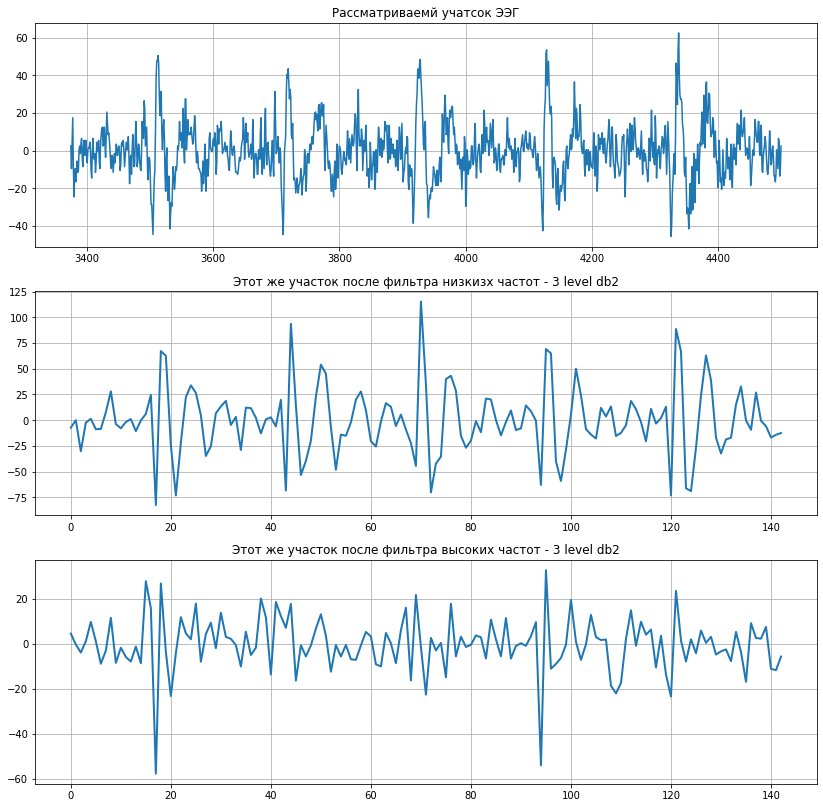

In [59]:
f = pyedflib.EdfReader('2021.02.19-19.01.21.775.edf')  
n = f.signals_in_file  
signal_labels = f.getSignalLabels() 
sigbufs = np.zeros((n, f.getNSamples()[0]))

for i in np.arange(n):
    sigbufs[i, :] = f.readSignal(i)
    
f.close()

chanel_num = 3     # номер рассматриваемого канала
start_sec = 27#25      # начало учатска
stop_sec = 36#36      # конец участка

x_data = [i for i in range(len(sigbufs[chanel_num]))][start_sec * 125 : stop_sec * 125]
y_data = [sigbufs[chanel_num][i] for i in range(len(sigbufs[chanel_num]))][start_sec * 125 : stop_sec * 125]

st = 'db2'        # тип преобразования
lvl = 3           # уровень преобразования (кол-во применений к данному сигналу)

cA = pywt.downcoef('a', y_data, st, mode = 'reflect', level = lvl)
cD = pywt.downcoef('d', y_data, st, mode = 'reflect', level = lvl)

plt.figure(figsize = (14, 14))
subplot(3, 1, 1)
title("Рассматриваемй учатсок ЭЭГ")
plot(x_data, y_data)
grid()

subplot(3, 1, 2)
title("Этот же участок после фильтра низкизх частот - 3 level %s"%st)
plt.plot([i for i in range(len(cA))], cA, linewidth = 2)
grid()

subplot(3, 1, 3)
title("Этот же участок после фильтра высоких частот - 3 level %s"%st)
plt.plot([i for i in range(len(cD))], cD, linewidth = 2)
grid()

plt.show()

In [60]:

data = copy(cA)
threshold = 0.56
columns_ = ['Left', 'Max', 'Zero', 'Min', 'Right']
index_ = [i for i in range(int(1.5 * (stop_sec - start_sec)))]
peaks_ind_df = pd.DataFrame(index = index_, columns = columns_)

#steps_num = len(data)
#steps_num = (int(stop_sec - start_sec) * 125)//(2 ** lvl)

for i in range(int(1.5 * (stop_sec - start_sec))): #предполагается, что моргают уж никак не чаще чем полтора раза в секунду
    
    #поиск max:
    max_ = max(data)
    max_ind =  np.where(data == max_)[0][0]
    
    #поиск min:
    min_ = min(data[max_ind : max_ind + 6])
    min_ind =  np.where(data == min_)[0][0]
    
    #нахождение левого/правого концов пика:
    if (abs(min_/max_) >= threshold) and (min_ * max_ < 0):
        
        #поиск левого края
        for j in range(6):
            if data[max_ind - j] < 0.05 * max_:
                left_ind = max_ind - j
                break
        
        #поиск правого края
        for j in range(6):
            if data[min_ind + j] > 0.05 * min_:
                right_ind = min_ind + j
                break
                
        #запись в датафрейм
        peaks_ind_df['Max'][i] = max_ind
        peaks_ind_df['Min'][i] = min_ind 
        peaks_ind_df['Left'][i] = left_ind
        peaks_ind_df['Right'][i] = right_ind

        #нахождение точки пересения нуля:
        peaks_ind_df['Zero'][i] = max_ind + (min_ind - max_ind) * (max_ / (max_ - min_))
    
    k = 3
    
    #обнуляем в копии записи место, в котором нашли пик
    data[left_ind - k : right_ind + k] = 0
    
    #если точкизакончились
    if (i >= 1) and ((peaks_ind_df['Right'][i - 1] == right_ind) or (peaks_ind_df['Left'][i - 1] == left_ind)):
        peaks_ind_df = peaks_ind_df.drop(index_[i:])
        break
        
peaks_ind_df = peaks_ind_df.sort_values('Left').reset_index(drop = True)
peaks_ind_df

,Left,Max,Zero,Min,Right
0,17,18,19.435,21,23
1,43,44,45.2741,46,49
2,69,70,71.243,72,75
3,94,95,96.6174,98,100
4,120,121,122.687,124,126


In [61]:
#найдём истинные точки пересения нуля 

def zero_intersection(x_1, x_2):
    return x_1 + (x_2 - x_1) * ( data[x_1] / (data[x_1] - data[x_2]))

    
data = copy(cA)
len_df = len(peaks_ind_df)
columns_ = ['Left', 'Max', 'Center', 'Min', 'Right']
index_ = [i for i in range(len_df)]
true_pos_df = pd.DataFrame(index = index_, columns = columns_)

for i in range(len_df):
    
    left_ind = peaks_ind_df['Left'][i]
    max_ind = peaks_ind_df['Max'][i]
    min_ind = peaks_ind_df['Min'][i]
    right_ind = peaks_ind_df['Right'][i]
    
    true_pos_df['Left'][i] = zero_intersection(left_ind, max_ind)
    true_pos_df['Max'][i] = max_ind
    true_pos_df['Center'][i] = zero_intersection(max_ind, min_ind)
    true_pos_df['Min'][i] = min_ind
    true_pos_df['Right'][i] = zero_intersection(min_ind, right_ind)
    
true_pos_df

,Left,Max,Center,Min,Right
0,17.5514,18,19.435,21,22.5333
1,43.422,44,45.2741,46,48.1011
2,69.278,70,71.243,72,73.9131
3,94.4766,95,96.6174,98,99.8355
4,120.452,121,122.687,124,125.484


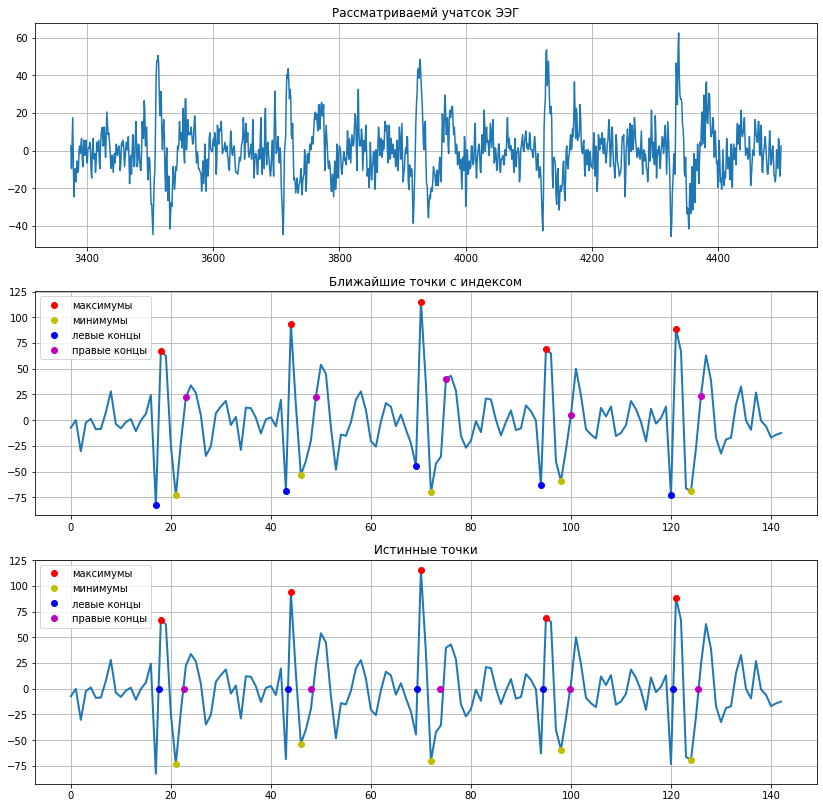

In [62]:
#визуализация пика

plt.figure(figsize = (14, 14))

subplot(3, 1, 1)
title("Рассматриваемй учатсок ЭЭГ")
plot(x_data, y_data)
grid()



subplot(3, 1, 2)
title("Ближайшие точки с индексом")
plt.plot([i for i in range(len(cA))], cA, linewidth = 2)

len_df = len(peaks_ind_df['Max'])
tmp = [peaks_ind_df['Max'][i] for i in range(len_df)]
plt.plot(tmp, cA[tmp], 'ro', label = 'максимумы')


tmp = [peaks_ind_df['Min'][i] for i in range(len_df)]
plt.plot(tmp, cA[tmp], 'yo', label = 'минимумы')


tmp = [peaks_ind_df['Left'][i] for i in range(len_df)]
plt.plot(tmp, cA[tmp], 'bo', label = 'левые концы')


tmp = [peaks_ind_df['Right'][i] for i in range(len_df)]
plt.plot(tmp, cA[tmp], 'mo', label = 'правые концы')

#tmp = [peaks_ind_df['Zero'][i] for i in range(len_df)]
#plt.plot(tmp, [0] * len_df, 'ko', label = 'точки пересечения нуля')

grid()
legend(loc = 'best')



subplot(3, 1, 3)
title("Истинные точки")
plt.plot([i for i in range(len(cA))], cA, linewidth = 2)

len_df = len(true_pos_df['Max'])
tmp = [true_pos_df['Max'][i] for i in range(len_df)]
plt.plot(tmp, cA[tmp], 'ro', label = 'максимумы')


tmp = [true_pos_df['Min'][i] for i in range(len_df)]
plt.plot(tmp, cA[tmp], 'yo', label = 'минимумы')


tmp = [true_pos_df['Left'][i] for i in range(len_df)]
plt.plot(tmp, [0] * len_df, 'bo', label = 'левые концы')


tmp = [true_pos_df['Right'][i] for i in range(len_df)]
plt.plot(tmp,  [0] * len_df, 'mo', label = 'правые концы')

#tmp = [peaks_ind_df['Zero'][i] for i in range(len_df)]
#plt.plot(tmp, [0] * len_df, 'ko', label = 'точки пересечения нуля')

grid()
legend(loc = 'best')

plt.show()

In [63]:
# фичи

data = copy(cA)
columns_ = ['User', 'Max_A', 'Min_A', 'Max_pos', 'Min_pos', 'Left_tan','Center_tan', 'Right_tan', 'Left_s', 'Right_s']
index_ = [i for i in range(len_df)]
features_df_test = pd.DataFrame(index = index_, columns = columns_)

for i in range(len_df):
    
    features_df_test['User'][i] = 1
    
    features_df_test['Max_A'][i] = data[peaks_ind_df['Max'][i]]
    features_df_test['Min_A'][i] = data[peaks_ind_df['Min'][i]]
    
    features_df_test['Max_pos'][i] = peaks_ind_df['Zero'][i] - peaks_ind_df['Max'][i]
    features_df_test['Min_pos'][i] = peaks_ind_df['Min'][i] - peaks_ind_df['Zero'][i]
    
    features_df_test['Left_tan'][i] = (data[peaks_ind_df['Max'][i]] - data[peaks_ind_df['Left'][i]]) / (peaks_ind_df['Max'][i] - peaks_ind_df['Left'][i])
    features_df_test['Right_tan'][i] = (data[peaks_ind_df['Right'][i]] - data[peaks_ind_df['Min'][i]]) / (peaks_ind_df['Right'][i] - peaks_ind_df['Min'][i])
    features_df_test['Center_tan'][i] = (data[peaks_ind_df['Min'][i]] - data[peaks_ind_df['Max'][i]]) / (peaks_ind_df['Min'][i] - peaks_ind_df['Max'][i])

    features_df_test['Left_s'][i] = 0.5 * data[peaks_ind_df['Max'][i]] * (peaks_ind_df['Zero'][i] - true_pos_df['Left'][i])
    features_df_test['Right_s'][i] = 0.5 * data[peaks_ind_df['Min'][i]] * (true_pos_df['Right'][i] - peaks_ind_df['Zero'][i])

features_df_test

,User,Max_A,Min_A,Max_pos,Min_pos,Left_tan,Center_tan,Right_tan,Left_s,Right_s
0,1,67.12,-73.1983,1.43502,1.56498,149.61,-46.7728,47.7379,63.2156,-113.396
1,1,93.6627,-53.3676,1.27406,0.72594,162.057,-73.5151,25.3998,86.7327,-75.4362
2,1,115.295,-70.222,1.24296,0.75704,159.696,-92.7587,36.705,113.273,-93.7528
3,1,69.1438,-59.105,1.61741,1.38259,132.111,-42.7496,32.2014,74.0112,-95.1018
4,1,88.5824,-68.9825,1.68659,1.31341,161.755,-52.5216,46.4689,98.9564,-96.5029


In [64]:
#нормализцаия
df = features_df_test

len_df = len(df)
mu = [sum(df[str_]) / len_df for str_ in list(df.columns.values)]
sigma = [np.sqrt(sum((df[str_] - mu[np.where(df.columns.values == str_)[0][0]]) ** 2) / len_df) for str_ in list(df.columns.values)]

print(len(mu), len(sigma))

for str_ in list(df.columns.values):
    if str_ != 'User':
        for i in range(len(df[str_])):
            current_ind = np.where(df.columns.values == str_)[0][0]
            df[str_][i] = (df[str_][i]  - mu[current_ind]) / sigma[current_ind]

df

10 10


,User,Max_A,Min_A,Max_pos,Min_pos,Left_tan,Center_tan,Right_tan,Left_s,Right_s
0,1,-1.11148,-1.09809,-0.0910411,1.21441,-0.301036,0.791344,1.18239,-1.35676,-1.54131
1,1,0.390578,1.55,-0.99642,-1.23385,0.789475,-0.62983,-1.44955,-0.028529,1.6114
2,1,1.61478,-0.700645,-1.17135,-1.14311,0.582684,-1.65249,-0.117536,1.47047,0.0901244
3,1,-0.996958,0.783861,0.934859,0.682201,-1.8342,1.00515,-0.648171,-0.747034,-0.0219235
4,1,0.103084,-0.53513,1.32395,0.480352,0.763079,0.485831,1.03287,0.661854,-0.138292


In [65]:
#X-train - признаки
#Y-train - номер пользователя (1 -я, 2 - Волид)

max_abs_list = [sign(df[str_][0]) * max(abs(df[str_])) for str_ in list(df.columns.values)][1:]
print(max_abs_list)

[-1.6147778367928987, -1.550000524277042, -1.3239498605968751, 1.233852703585019, -1.8342018324858658, 1.6524928920114994, 1.4495506560004958, -1.4704690975997832, -1.6114046761665854]


In [66]:
y_data = list(df['User'])
x_data = [[df[df.columns[i]][j] / max_abs_list[i - 1] for j in range(len(df.index))] for i in range(1, len(df.columns))]
x_data = np.array(x_data).transpose()

In [67]:
# объеденим с train:

#x_data = np.concatenate((x_data, x_test), axis = 1)
#print(x_data, x_test)

x_data = [tmp for tmp in x_data]
for tmp in x_test:
    x_data.append(tmp)
    
y_data = [tmp for tmp in y_data]
for tmp in y_test:
    y_data.append(tmp)
    
copy(y_data)

array([1, 1, 1, 1, 1, 1, 2, 1, 2])

# # Метод опорных векторов:

In [68]:
y_pred_1 = clf_1.predict(x_data)
print(y_pred_1)

#ВАУ, с нормализацией точность повысилась!
#истинное значение 1

[1 1 2 1 1 1 2 1 2]


# # Случайный лес:

In [69]:
y_pred_2 = clf_2.predict(x_data)
print(y_pred_2)

[1 2 2 1 1 1 2 1 2]


# # K ближайших соседей:

In [70]:
y_pred_3 = clf_3.predict(x_data)
print(y_pred_3)

[2 1 1 1 1 1 2 1 2]


# # Сравнение метрик: 

In [71]:
#Сравнение разных метрик
#в данном случае 1 - верно угаданные, 2 - неверно

def metrics(data_y_pred, y_test, str_):
    
    y_test -= 1
    data_y_pred -= 1
    
    test_len = len(y_test)
    pos_num = sum(y_test)
    neg_num = test_len - pos_num

    true_pos = 0
    true_neg = 0
    for i in range(test_len):
        if data_y_pred[i] == y_test[i] == 1:
            true_pos += 1
        if data_y_pred[i] == y_test[i] == 0:
            true_neg += 1

    false_pos = pos_num - true_pos
    false_neg = neg_num - true_neg

    print('accuracy for', str_, '=', (true_pos + true_neg) / test_len)
    #print('precision = ', true_pos / (true_pos + false_pos))
    #print('recall = ', true_pos / (true_pos + false_neg))
    

metrics(copy(y_pred_1), copy(y_data), 'SVM')
metrics(copy(y_pred_2), copy(y_data), 'RF')
metrics(copy(y_pred_3), copy(y_data), 'kNN')

accuracy for SVM = 0.8888888888888888
accuracy for RF = 0.7777777777777778
accuracy for kNN = 0.8888888888888888
